### MAST30034: Applied Data Science Project 1
---
# Data Analysis: FHVHV Dataset
#### Xavier Travers (1178369)

Performs data analysis to relate the COVID dataset and FHVHV aggregate dataset

In [1]:
# imports used throughout this notebook
from pyspark.sql import DataFrame, Column
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import os

DEBUGGING = False

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .getOrCreate()
)

22/08/07 13:28:02 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.28.235.139 instead (on interface eth0)
22/08/07 13:28:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/07 13:28:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/07 13:28:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/07 13:28:04 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
# read in the aggregated dataset
fhvhv_df = spark.read.parquet('../data/curated/tlc/aggregated/fhvhv')
# create a view
fhvhv_df.createOrReplaceTempView("fhvhv")

In [4]:
# fhvhv_df = pd.read_parquet('../data/curated/tlc/aggregated')

In [5]:
# sort by year, month, type
fhvhv_df = fhvhv_df.sort('month_index', 'type')

In [6]:
# sanity check on read
fhvhv_df.limit(5)

year,month,type,PUborough,DOborough,shared,total_trips,total_distance,avg_distance,month_index
2019,7,juno,Staten Island,Bronx,0.0,11,384.96999999999997,34.99727272727272,0
2019,7,juno,Bronx,Staten Island,0.0,9,289.69000000000005,32.18777777777778,0
2019,7,juno,Staten Island,Staten Island,0.0,2237,7800.540000000007,3.4870540902995115,0
2019,7,juno,Brooklyn,EWR,0.0,614,11922.120000000015,19.417133550488625,0
2019,7,juno,Brooklyn,Manhattan,0.0,21931,151653.4899999998,6.915028498472473,0


In [7]:
# read in the covid dataset
covid_df = spark.read.parquet('../data/curated/covid/cases-by-month')
# create a view
covid_df.createOrReplaceTempView("covid")

In [8]:
# sanity check on read
covid_df.limit(5)

year,month,num_days,total_case_count,total_hospitalized_count,total_death_count,avg_case_count,avg_hospitalized_count,avg_death_count,borough,month_index
2020,3,31,65182,18427,2183,2102.6451612903224,594.4193548387096,70.41935483870968,Overall,8
2020,4,30,109297,27565,12713,3643.233333333333,918.8333333333334,423.76666666666665,Overall,9
2020,5,31,28417,3910,2816,916.6774193548387,126.12903225806451,90.83870967741936,Overall,10
2020,6,30,10844,1528,675,361.46666666666664,50.93333333333333,22.5,Overall,11
2020,7,31,9786,1150,239,315.6774193548387,37.096774193548384,7.709677419354839,Overall,12


In [9]:
def joinOnBoroughs(tlc_df, covid_df):
    tlc_df.createOrReplaceTempView('tlc')

    col_selections = f'''
    tlc.month_index,
    tlc.year,
    tlc.month,
    tlc.type,
    tlc.PUborough,
    tlc.DOborough,
    tlc.shared,
    tlc.total_trips,
    tlc.avg_distance,
    tlc.total_distance,
    pu.month_index AS pu_month_index,
    pu.year AS pu_year,
    pu.month AS pu_month,
    pu.num_days,
    pu.total_case_count AS pu_total_case_count,
    pu.total_hospitalized_count AS pu_total_hospitalized_count,
    pu.total_death_count AS pu_total_death_count,
    pu.avg_case_count AS pu_avg_case_count,
    pu.avg_hospitalized_count AS pu_avg_hospitalized_count,
    pu.avg_death_count AS pu_avg_death_count,
    do.total_case_count AS do_total_case_count,
    do.total_hospitalized_count AS do_total_hospitalized_count,
    do.total_death_count AS do_total_death_count,
    do.avg_case_count AS do_avg_case_count,
    do.avg_hospitalized_count AS do_avg_hospitalized_count,
    do.avg_death_count AS do_avg_death_count
    '''

    covid_df.createOrReplaceTempView('covid')

    return spark.sql(
    f'''
    SELECT {col_selections}
    FROM tlc, covid AS pu, covid AS do
    WHERE tlc.year == pu.year
    AND tlc.month_index == pu.month_index + 1
    AND tlc.PUborough == pu.borough
    AND tlc.month_index == do.month_index + 1
    AND tlc.PUborough == do.borough
    '''
)

In [10]:
# join the datasets on PUBorough and DOBorough
joint_df = joinOnBoroughs(fhvhv_df, covid_df)

In [11]:
# sanity check on join
joint_df.sort('month_index').limit(5)

22/08/07 13:28:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


month_index,year,month,type,PUborough,DOborough,shared,total_trips,avg_distance,total_distance,pu_month_index,pu_year,pu_month,num_days,pu_total_case_count,pu_total_hospitalized_count,pu_total_death_count,pu_avg_case_count,pu_avg_hospitalized_count,pu_avg_death_count,do_total_case_count,do_total_hospitalized_count,do_total_death_count,do_avg_case_count,do_avg_hospitalized_count,do_avg_death_count
9,2020,4,uber,Bronx,Bronx,1.0,1,0.74,0.74,8,2020,3,31,12681,3805,467,409.06451612903226,122.74193548387096,15.064516129032258,12681,3805,467,409.06451612903226,122.74193548387096,15.064516129032258
9,2020,4,via,Queens,Manhattan,0.0,1600,8.914656249999997,14263.449999999995,8,2020,3,31,19983,6000,656,644.6129032258065,193.5483870967742,21.161290322580644,19983,6000,656,644.6129032258065,193.5483870967742,21.161290322580644
9,2020,4,via,Staten Island,Manhattan,0.0,2,27.3,54.6,8,2020,3,31,4461,750,111,143.90322580645162,24.193548387096776,3.5806451612903225,4461,750,111,143.90322580645162,24.193548387096776,3.5806451612903225
9,2020,4,lyft,Brooklyn,Bronx,0.0,4135,18.721724788391754,77414.33199999991,8,2020,3,31,18516,5319,662,597.2903225806451,171.58064516129033,21.35483870967742,18516,5319,662,597.2903225806451,171.58064516129033,21.35483870967742
9,2020,4,uber,Manhattan,Brooklyn,0.0,62813,8.926547529969852,560703.2299999964,8,2020,3,31,9538,2729,287,307.6774193548387,88.03225806451613,9.258064516129032,9538,2729,287,307.6774193548387,88.03225806451613,9.258064516129032


In [12]:
# define the types of fhvhv companies
FHVHV_TYPES = [
    'uber',
    '']

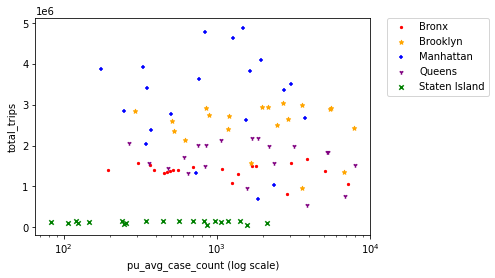

In [13]:
import sys
sys.path.insert(1, '../scripts')
from helpers.plot_helpers import group_plot

# iterate over the 4 major fhvhv companies and generate scatter plots of trips vs avg cases monthly

pandas_df = joint_df\
    .groupBy('year', 'month', 'type', 'PUborough', 'num_days')\
    .agg(
        F.sum('pu_total_case_count').alias('pu_total_case_count'),
        (F.sum('pu_total_case_count') / F.col('num_days')).alias('pu_avg_case_count'),
        F.sum('total_trips').alias('total_trips')
    )\
    .where((F.col('type') == 'uber'))\
    .toPandas()
group_plot(pandas_df, 'pu_avg_case_count', 'total_trips', 'PUborough', 'fhvhv-uber',
    logx=True)


### 1. Total monthly trips versus COVID case rates

Starts with a scatter plot, then chooses an applicable form of regression.
Also performs hypothesis tests to determine the reliability of the selected regression model.

In [14]:
#